# Circuit library demo

In [1]:
from qiskit.circuit.library import QuantumVolume, FourierChecking, WeightedAdder #,  ...

### Chemistry example: Variational Quantum Eigensolver

In [2]:
# simulator
from qiskit import Aer

# the actual algorithm
from qiskit.aqua.algorithms import VQE

# for representation of the H2 molecule
from qiskit.aqua.operators import WeightedPauliOperator

# optimizer for the variational algorithm
from qiskit.aqua.components.optimizers import SLSQP

In [3]:
# building the qubit operator for the H2 molecule
h2_hamiltonian = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
               {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "IZ"},
               {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "ZI"},
               {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
               {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}
               ]
}
h2_qubit_operator = WeightedPauliOperator.from_dict(h2_hamiltonian)

# defining the backend for the simulation
backend = Aer.get_backend('statevector_simulator')

# defining the numerical optimizer
optimizer = SLSQP()

The algorithm uses a "guess" or "Ansatz" wavefunction: this comes from our circuit library.

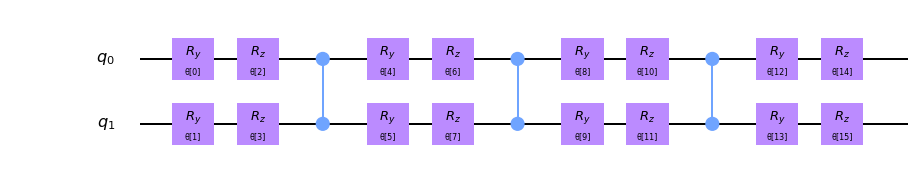

In [4]:
from qiskit.circuit.library import RYRZ  # Kandala et al., Nature Cover 
varform = RYRZ(h2_qubit_operator.num_qubits)
varform.draw(scale=1, output='mpl')

In [5]:
# run the algorithm
algo = VQE(h2_qubit_operator, varform, optimizer=optimizer, quantum_instance=backend)
result = algo.compute_minimum_eigenvalue()

In [6]:
print('Energy:', result['eigenvalue'].real)
print('Optimal parameters:', result['optimal_point'])

Energy: -1.8572749538592355
Optimal parameters: [ 0.05149911  0.41794549 -1.87552336  0.06836094  0.59734492 -2.93636169
 -1.88960097 -1.03848127  0.68987157 -2.51715307  0.58197612 -1.64592804
 -0.05490746 -0.38971754 -0.97332264 -2.40445358]


Plug-n-play: circuit library has plentiful options, e.g. `TwoLocal`, `NLocal`, `RY`, ... .

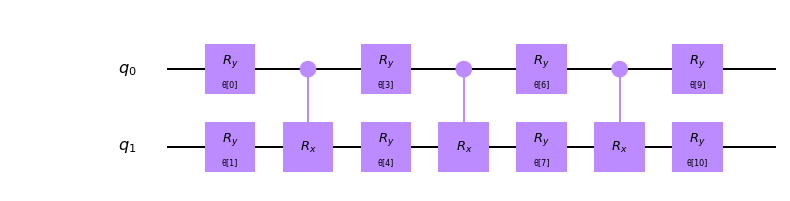

In [7]:
from qiskit.circuit.library import TwoLocal

# easy to implement all efficient 2-local circuits, e.g. all of Alan Aspuru-Guzik's Paper
varform = TwoLocal(h2_qubit_operator.num_qubits, 
                   rotation_blocks='ry',
                   entanglement_blocks='crx',
                   entanglement='linear', 
                   reps=3)
varform.draw(scale=1.2, output='mpl')

In [8]:
algo = VQE(h2_qubit_operator, varform, optimizer=SLSQP(), quantum_instance=backend)
result = algo.compute_minimum_eigenvalue()

In [9]:
print('Energy:', result['eigenvalue'].real)
print('Optimal parameters:', result['optimal_point'])

Energy: -1.857274905615748
Optimal parameters: [-4.29572621 -1.2806668   3.80962385  5.40578658  0.48584993  3.33120281
  6.88411738  4.75456922  1.92170827  0.7727848  -5.74463275]


### Circuit mutability

An important feature of the circuit library is, that the circuits can be passed around as blueprints. The structure can be specified upfront, but only once all information is available we set the missing parts, e.g. the number of qubits.

![alt text](./mutability.png)

In [ ]:
class VariationalQuantumEigensolver:
    def __init__(self, guess_wavefunction):
        # store the guess wavefunction
        self.guess_wavefunction = guess_wavefunction
        
    def compute_minumum_eigenvalue(self, hamiltonian):
        # adjust guess wavefunction to size of the Hamiltonian
        self.guess_wavefunction.num_qubits = hamiltonian.num_qubits
        # run the iterative algorithm...
        
class QuadraticUnconstrainedBinaryOptimizer:
    def __init__(self, variational_quantum_eigensolver):
        # store the algorithm uses as subroutine
        self.vqe = variational_quantum_eigensolver
        
    def solve(self, problem):
        # the Variational Quantum Eigensolver must run for any problem size! 
        solution = self.vqe.compute_minimum_eigenvalue(problem)

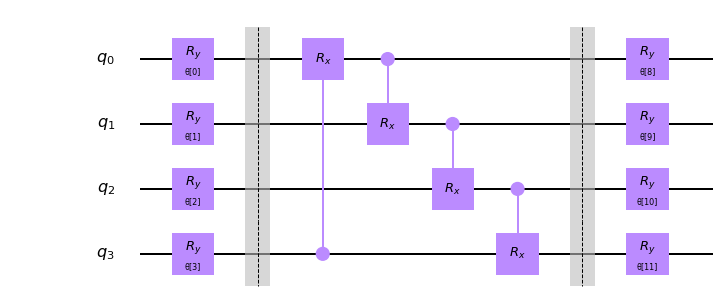

In [10]:
varform.num_qubits = 4
varform.reps = 1
varform.insert_barriers = True
varform.entanglement = 'circular'
varform.rotation_gates = ['z', 'ry']
varform.draw(scale=1, output='mpl')

### Machine learning example: Variational Quantum Classifier

In [18]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [19]:
# the algorithm
from qiskit.aqua.algorithms import VQC

# the training and test data
from sample import training_data, test_data, feature_dimension

In [20]:
# fix the random seeds
from qiskit.aqua import aqua_globals
from numpy import random

aqua_globals.seed = 373
random.seed = 53
seed_simulator, seed_transpiler = 981, 74

In [21]:
from qiskit.circuit.library import SecondOrderExpansion
feature_map = SecondOrderExpansion(feature_dimension=feature_dimension, depth=1)  # Havlicek et al., Nature Cover

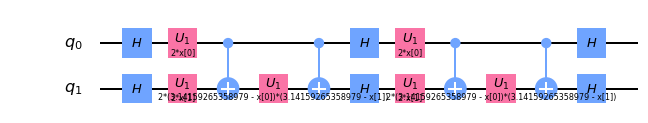

In [22]:
feature_map.draw(output='mpl')

In [23]:
varform = RYRZ(num_qubits=feature_map.num_qubits, reps=1)

In [24]:
vqc = VQC(optimizer, feature_map, varform, training_data, test_data)
result = vqc.run(backend, seed_simulator=seed_simulator, seed_transpiler=seed_transpiler)

In [25]:
print('Training loss:', result['training_loss'])
print('Test loss:', result['testing_loss'])

Training loss: 0.1295201003294418
Test loss: 1.2172340532672068


In [26]:
from qiskit.circuit.library import QFT

In [27]:
varform = QFT(2) + RYRZ(2, reps=2)

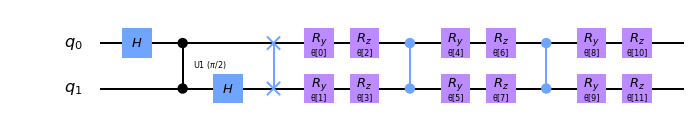

In [28]:
varform.draw(output='mpl')

In [29]:
vqc = VQC(optimizer, feature_map, varform, training_data, test_data)
result = vqc.run(backend, seed_simulator=seed_simulator, seed_transpiler=seed_transpiler)

In [30]:
print('Training loss:', result['training_loss'])
print('Test loss:', result['testing_loss'])

Training loss: 0.10581905313965678
Test loss: 0.7851322859180203
